## Dimensionality reduction with principle components

**Principle component analysis**, or **PCA**, is an alternative to regularization and straight-forward feature elimination. PCA is particularly useful for problems with very large numbers of features compared to the number of training cases. For example, when faced with a problem with many thousands of features and perhaps a few thousand cases, PCA can be a good choice to **reduce the dimensionality** of the feature space.  

PCA is one of a family of transformation methods that reduce dimensionality. PCA is the focus here, since it is the most widely used of these methods. 

The basic idea of PCA is rather simple: Find a linear transformation of the feature space which **projects the majority of the variance** onto a few orthogonal dimensions in the transformed space. The PCA transformation maps the data values to a new coordinate system defined by the principle components. Assuming the highest variance directions, or **components**, are the most informative, low variance components can be eliminated from the space with little loss of information. 

The projection along which the greatest variance occurs is called the **first principle component**. The next projection, orthogonal to the first, with the greatest variance is call the **second principle component**. Subsequent components are all mutually orthogonal with decreasing variance along the projected direction.  

Widely used PCA algorithms compute the components sequentially, starting with the first principle component. This means that it is computationally efficient to compute the first several components from a very large number of features. Thus, PCA can make problems with very large numbers of features computationally tractable. 

****
**Note:** It may help your understanding to realize that principle components are a scaled version of the **eigenvectors** of the feature matrix. The scale for each dimensions is given by the **eigenvalues**. The eigenvalues are the fraction of the variance explained by the components. 
****

## A simple example

To cement the concepts of PCA you will now work through a simple example. This example is restricted to 2-d data so that the results are easy to visualize. 

As a first step, execute the code in cell below to load the packages required for the rest of this notebook.

In [1]:
import pandas as pd
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import sklearn.decomposition as skde
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import math

%matplotlib inline

The code in the cell below simulates data from a bivariate Normal distribution. The distribution is deliberately centered on $\{ 0,0 \}$ and with unit variance on each dimension. There is considerable correlation between the two dimensions leading to a covariance matrix:

$$cov(X) =  \begin{bmatrix}
  1.0 & 0.6 \\
  0.6 & 1.0
 \end{bmatrix}$$

Given the covariance matrix 100 draws from this distribution are computed using the `multivariate_normal` function from the Numpy `random` package. Execute this code:

In [2]:
nr.seed(124)
cov = np.array([[1.0, 0.6], [0.6, 1.0]])
mean = np.array([0.0, 0.0])

sample = nr.multivariate_normal(mean, cov, 100)
sample.shape

(100, 2)

To get a feel for this data, execute the code in the cell below to display a plot and examine the result. 

Text(0.5,1,'Sample data')

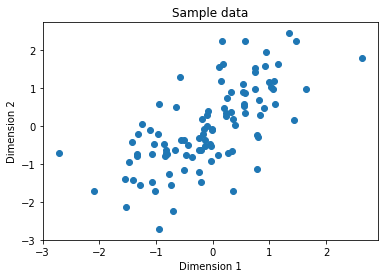

In [3]:
plt.scatter(sample[:,0], sample[:,1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Sample data')

You can see that the data have a roughly elliptical pattern. The correlation between the two dimensions is also visible. 

With the simulated data set created, it is time to compute the PCA model. The code in the cell below does the following:
1. Define a PCA model object using the `PCA` function from the scikit-learn `decomposition` package.
2. Fit the PCA model to the sample data.
3. Display the ratio of the **variance explained** by each of the components, where, for a matrix X, this ratio is given by:

$$VE(X) = \frac{Var_{X-component}(X)}{Var_{X-total}(X)}$$

Notice that by construction:

$$VE(X) = \sum_{i=1}^N VE_i(X) = 1.0$$

In other words, the sum of the variance explained for each component must add to the total variance or 1.0 for standardized data. 

Execute this code and examine the result.

In [4]:
pca_model = skde.PCA()
pca_fit = pca_model.fit(sample)
print(pca_fit.explained_variance_ratio_)

[0.84530942 0.15469058]


Notice that the explained variance of the first component is many times larger than for the second component. This is exactly the desired result indicating the first principle component explains the majority of the variance of the sample data. 

The code in the cell below computes and prints the scaled components. Mathematically, the scaled components are the eigenvectors scaled by the eigenvalues. Execute this code:  

In [5]:
comps = pca_fit.components_
for i in range(2):
    comps[:,i] = comps[:,i] * pca_fit.explained_variance_ratio_
print(comps)

[[ 0.51185182  0.67272262]
 [-0.12310741  0.09366825]]


Notice that the two vectors have their origins at $\[ 0,0 \}$, and are quite different magnitude, and are pointing in different directions.  

To better understand how the projections of the components relate to the data, execute the code to plot the data along with the principle components. Execute this code: 

Text(0.5,1,'Sample data')

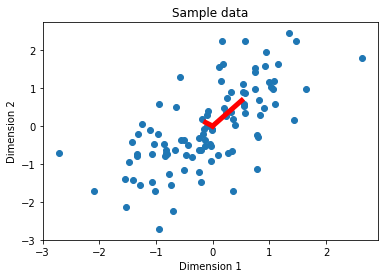

In [6]:
plt.scatter(sample[:,0], sample[:,1])
# plt.plot([0.0, comps[0,0]], [0.0,comps[0,1]], color = 'red', linewidth = 5)
# plt.plot([0.0, comps[1,0]], [0.0,comps[1,1]], color = 'red', linewidth = 5)
plt.plot([0.0, comps[0,0]], [0.0,comps[0,1]], color = 'red', linewidth = 5)
plt.plot([0.0, comps[1,0]], [0.0,comps[1,1]], color = 'red', linewidth = 5)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Sample data')

Notice the the fist principle component (the long red line) is along the direction of greatest variance of the data. This is as expected. The short red line is along the direction of the second principle component. The lengths of these lines is the variance in the directions of the projection. 

The ultimate goal of PCA is to transform data to a coordinate system with the highest variance directions along the axes. The code in the cell below uses the `transform` method on the PCA object to perform this operation and then plots the result. Execute this code: 

Text(0.5,1,'Sample data')

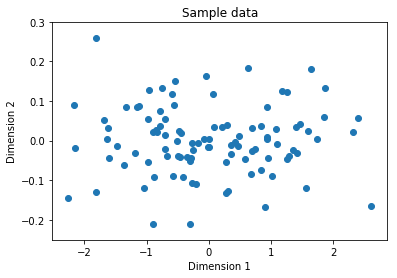

In [7]:
trans = pca_fit.transform(sample)
plt.scatter(trans[:,0], trans[:,1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Sample data')

Notice that the scale along these two coordinates are quite different. The first principle component is along the horizontal axis. The range of values on this direction is in the range of about $\{ -2.5,2.5 \}$. The range of values on the vertical axis or second principle component are only about $\{ -0.2, 0.3 \}$. It is clear that most of the variance is along the direction of the fist principle component. 

## Load Features and Labels

Keeping the foregoing simple example in mind, it is time to apply PCA to some real data. 

The code in the cell below loads the dataset which has had the the following preprocessing:
1. Cleaning missing values.
2. Aggregating categories of certain categorical variables. 
3. Encoding categorical variables as binary dummy variables.
4. Standardizing numeric variables. 

Execute the code in the cell below to load the features and labels as numpy arrays for the example: 

In [8]:
Features = np.array(pd.read_csv('Credit_Features.csv'))
Labels = np.array(pd.read_csv('Credit_Labels.csv'))
print(Features.shape)
print(Labels.shape)

(1000, 35)
(1000, 1)


There are 35 features in this data set. The numeric features have been Zscore scaled so they are zero centered (mean removed) and unit variance (divide by standard deviation). 

****
**Note:** Before performing PCA all features must be zero mean and unit variance. Failure to do so will result in biased computation of the components and scales. In this case, the data set has already been scaled, but ordinarily scaling is a key step. 
****

Now, run the code in the cell below to split the data set into test and training subsets:

In [9]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

## Compute principle components

The code in the cell below computes the principle components for the training feature subset. Execute this code:

In [10]:
pca_mod = skde.PCA()
pca_comps = pca_mod.fit(x_train)
pca_comps

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Execute the code in the cell below to print the variance explained for each component and the sum of the variance explained:

In [11]:
print(pca_comps.explained_variance_ratio_)
print(np.sum(pca_comps.explained_variance_ratio_))

[2.14454905e-01 1.45271147e-01 1.28532553e-01 5.55554330e-02
 4.91723911e-02 4.27625372e-02 3.78015441e-02 3.52905162e-02
 3.40935676e-02 2.98736044e-02 2.82623202e-02 2.63144677e-02
 2.40299754e-02 2.20162922e-02 1.72330465e-02 1.70031525e-02
 1.60567422e-02 1.37503175e-02 1.27040327e-02 1.02826434e-02
 9.12460219e-03 7.13807162e-03 6.43465948e-03 6.29150307e-03
 3.93792720e-03 2.95950712e-03 1.54556112e-03 1.20102653e-03
 9.05952167e-04 4.22937727e-32 5.01934563e-33 1.36948574e-33
 1.22248933e-33 6.27927224e-34 5.98198079e-34]
1.0000000000000002


These numbers are a bit abstract. However, you can see that the variance ratios are in descending order and that the sum is 1.0. 

Execute the code in the cell below to create a plot of the explained variance vs. the component:  

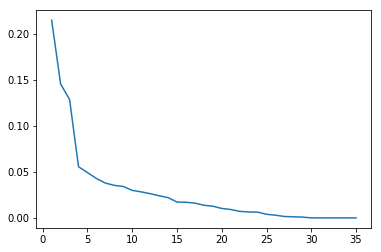

In [12]:
def plot_explained(mod):
    comps = mod.explained_variance_ratio_
    x = range(len(comps))
    x = [y + 1 for y in x]          
    plt.plot(x,comps)

plot_explained(pca_comps)

This curve is often referred to as a **scree plot**. Notice that the explained variance decreases rapidly until the 5th component and then slowly, thereafter. The first few components explain a large fraction of the variance and therefore contain much of the explanatory information in the data. The components with small explained variance are unlikely to contain much explanatory information. Often the inflection point or 'knee' in the scree curve is used to choose the number of components selected. 

Now it is time to create a PCA model with a reduced number of components. The code in the cell below trains and fits a PCA model with 5 components, and then transforms the features using that model. Execute this code. 

In [13]:
pca_mod_5 = skde.PCA(n_components = 5)
pca_mod_5.fit(x_train)
Comps = pca_mod_5.transform(x_train)
Comps.shape

(700, 5)

## Compute and evaluate a logistic regression model

Next, you will compute and evaluate a logistic regression model using the features transformed by the first 5 principle components. Execute the code in the cell below to define and fit a logistic regression model, and print the model coefficients. 

In [14]:
## Define and fit the logistic regression model
log_mod_5 = linear_model.LogisticRegression(C = 10.0, class_weight = {0:0.45, 1:0.55}) 
log_mod_5.fit(Comps, y_train)
print(log_mod_5.intercept_)
print(log_mod_5.coef_)

[-0.7970545]
[[ 0.351739   -0.03068638 -0.41888098  0.87147247 -0.65315369]]


Notice that there are now 5 regression coefficients, one for each component. This number is in contrast to the 35 features in the raw data. 

Next, evaluate this model using the code below. Notice that the test features are transformed using the same PCA transformation used for the training data. Execute this code and examine the results.

Then, answer **Question 1** on the course page.

                 Confusion matrix
                 Score positive    Score negative
True positive       122             90
True negative        17             71

Accuracy  0.64
 
             Positive   Negative
Num case    212.00       88.00
Precision   0.88          0.44
Recall      0.58          0.81
F1          0.70          0.57


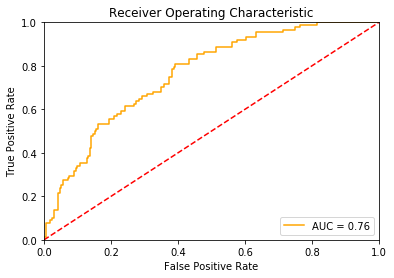

In [15]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('True positive    %6d' % conf[0,0] + '          %5d' % conf[0,1])
    print('True negative    %6d' % conf[1,0] + '          %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('             Positive   Negative')
    print('Num case    %0.2f' % metrics[3][0] + '       %0.2f' % metrics[3][1])
    print('Precision   %0.2f' % metrics[0][0] + '          %0.2f' % metrics[0][1])
    print('Recall      %0.2f' % metrics[1][0] + '          %0.2f' % metrics[1][1])
    print('F1          %0.2f' % metrics[2][0] + '          %0.2f' % metrics[2][1])
    
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

probabilities = log_mod_5.predict_proba(pca_mod_5.transform(x_test))
scores = score_model(probabilities, 0.3)
print_metrics(y_test, scores)    
plot_auc(y_test, probabilities)     

For the most part, these results look good. The question remains, were the correct number of principle components used? 

## Add more components to the model

Now you will compute and evaluate a logistic regression model using the first 10 principle components. You will compare this model to the one created with 5 principle components. Execute the code below to transform the training features using the first 10 principle components. 

In [16]:
pca_mod_10 = skde.PCA(n_components = 10)
pca_mod_10.fit(x_train)
Comps_10 = pca_mod_10.transform(x_train)
Comps_10.shape

(700, 10)

Execute the code in the cell below to define and fit a logistic regression model using the 10 components of the transformed features. 

In [17]:
## define and fit the linear regression model
log_mod_10 = linear_model.LogisticRegression(C = 100) 
log_mod_10.fit(Comps_10, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The code in the cell below scores the logistic regression model and displays performance metrics, the ROC curve, and the AUC. Execute this code and examine the result. 

Then, answer **Question 2** on the course page.

                 Confusion matrix
                 Score positive    Score negative
True positive       141             71
True negative        21             67

Accuracy  0.69
 
             Positive   Negative
Num case    212.00       88.00
Precision   0.87          0.49
Recall      0.67          0.76
F1          0.75          0.59


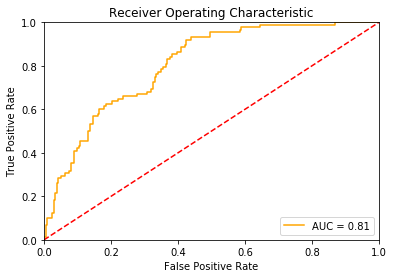

In [18]:
probabilities = log_mod_10.predict_proba(pca_mod_10.transform(x_test))
scores = score_model(probabilities, 0.3)
print_metrics(y_test, scores)  
plot_auc(y_test, probabilities)     

All of the metrics have improved compared to the 5 component model. Apparently there is useful information in the first 10 components. 

But, is this difference really significant. To find out, you will now perform cross validation on the result. Ideally, the fitting of the PCA model should be part of the cross validation process. However, at the risk of a small bias, this step is omitted for the sake of simplicity. Execute the code in the cell below to perform the cross validation and display the result. 

In [19]:
def print_format(f,x,y,z):
    print('Fold %1d   %4.3f        %4.3f      %4.3f' % (f, x, y, z))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_precision_macro']))]
    print('         Precision    Recall,    AUC')
    [print_format(f,x,y,z) for f,x,y,z in zip(fold, scores['test_precision_macro'], 
                                          scores['test_recall_macro'],
                                          scores['test_roc_auc'])]
    print('-' * 40)
    print('Mean     %4.3f        %4.3f      %4.3f' % 
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro']), np.mean(scores['test_roc_auc'])))  
    print('Std      %4.3f        %4.3f      %4.3f' % 
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro']), np.std(scores['test_roc_auc'])))

Labels = Labels.reshape(Labels.shape[0],)
scoring = ['precision_macro', 'recall_macro', 'roc_auc']

pca_mod = skde.PCA(n_components = 10)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)
scores = ms.cross_validate(log_mod_10, Comps, Labels, scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores)  

         Precision    Recall,    AUC
Fold 1   0.672        0.636      0.770
Fold 2   0.729        0.693      0.801
Fold 3   0.638        0.593      0.789
Fold 4   0.642        0.612      0.703
Fold 5   0.709        0.640      0.807
Fold 6   0.688        0.643      0.790
Fold 7   0.629        0.626      0.673
Fold 8   0.781        0.714      0.816
Fold 9   0.705        0.650      0.766
Fold 10   0.677        0.674      0.720
----------------------------------------
Mean     0.687        0.648      0.764
Std      0.044        0.035      0.046


Compare the AUC and its standard deviation obtained above to the AUC of the 5 component model. The difference does appear to be significant. This difference supports the hypothesis that the first 10 components all contain useful information. 

## Summary

In this lab you have applied principle component analysis to dimensionality reduction for supervised machine learning. The first components computed contain most of the available information. When faced with large number of features, PCA is an effective way to make supervised machine learning models tractable. 

Specifically in this lab you have:
1. Computed PCA models with different numbers of components.
2. Compared logistic regression models with different numbers of components. In this case, using 10 components produced a significantly better model. Using 10 components is a useful reduction in dimensionality compared to the original 35 features. 